In [19]:
# Importing required libraries
import pandas as pd
import numpy as np
import random

import psycopg2
import sys

import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import matplotlib.animation as ani
from IPython.display import HTML

from sklearn.metrics import r2_score
from sklearn.metrics import confusion_matrix
from sklearn.tree import DecisionTreeClassifier



import bar_chart_race as bcr


pd.options.mode.chained_assignment = None 
pd.set_option('display.max_columns', None)

import warnings 
warnings.filterwarnings("ignore")

from scipy.spatial.distance import pdist, squareform


# libraries recommended by chatGPT

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import classification_report

from ipywidgets import interact, fixed
from IPython.display import display

import ipywidgets as widgets
from ipywidgets import interactive
from tensorflow import keras

In [2]:
# Store environment variable
from getpass import getpass
dbPassword = getpass('Enter database password')

In [5]:
param_dic = {
        'database': 'big-data-bowl',
        'user': 'postgres',
        'password': dbPassword,
        'host': '34.72.136.99',
        'port': 5432,
}
def connect(params_dic):
    """ Connect to the PostgreSQL database server """
    conn = None
    try:
        # connect to the PostgreSQL server
        print('Connecting to the PostgreSQL database...')
        conn = psycopg2.connect(**params_dic)
    except (Exception, psycopg2.DatabaseError) as error:
        print(error)
        sys.exit(1) 
    print("Connection successful")
    return conn

In [6]:
def postgresql_to_dataframe(conn, select_query, column_names):
    """
    Tranform a SELECT query into a pandas dataframe
    """
    cursor = conn.cursor()
    try:
        cursor.execute(select_query)
    except (Exception, psycopg2.DatabaseError) as error:
        print("Error: %s" % error)
        cursor.close()
        return 1
    
    # Naturally we get a list of tupples
    tupples = cursor.fetchall()
    cursor.close()
    
    # We just need to turn it into a pandas dataframe
    df = pd.DataFrame(tupples, columns=column_names)
    return df

In [48]:
conn = connect(param_dic)
column_names = [
"gameId", 
"playId", 
"nflId",
"displayName",
"officialPosition",
"height",
"weight",
"team",
"playDescription",
"down",
"yardsToGo",
"defendersInBox",
"frameId",
"a",
"s",
"pff_positionLinedUp",
"pff_hitAllowed",
"pff_hurryAllowed",
"pff_sackAllowed",
"pff_beatenByDefender",
"pff_hit",
"pff_hurry",
"pff_sack"
]
query = f"SELECT trd.\"gameId\",    \
trd.\"playId\",                     \
trd.\"nflId\",                      \
pl.\"displayName\",                 \
pl.\"officialPosition\",            \
pl.\"height\",                      \
pl.\"weight\",                      \
trd.\"team\",                       \
ply.\"playDescription\",            \
ply.\"down\",                       \
ply.\"yardsToGo\",                  \
ply.\"defendersInBox\",             \
trd.\"frameId\",                    \
trd.\"a\",                          \
trd.\"s\",                          \
pff.\"pff_positionLinedUp\",        \
pff.\"pff_hitAllowed\",             \
pff.\"pff_hurryAllowed\",           \
pff.\"pff_sackAllowed\",            \
pff.\"pff_beatenByDefender\",       \
pff.\"pff_hit\",                    \
pff.\"pff_hurry\",                  \
pff.\"pff_sack\"                    \
FROM trackingdata as trd            \
LEFT JOIN players as pl             \
ON trd.\"nflId\" = pl.\"nflID\"     \
LEFT JOIN plays as ply              \
ON trd.\"playId\" = ply.\"playId\"  \
AND trd.\"gameId\" = ply.\"gameId\" \
LEFT JOIN pffscoutingdata as pff    \
ON trd.\"playId\" = pff.\"playId\"  \
AND trd.\"gameId\" = pff.\"gameId\" \
AND pl.\"nflID\" = pff.\"nflId\"    \
WHERE pl.\"officialPosition\" IN ('DE','DT','NT','OLB','ILB','MLB','FS','SS','CB','QB','C', 'G', 'T', 'TE') "

# Execute the "SELECT" query
pff_joined_df = postgresql_to_dataframe(conn, query, column_names)

# df = pff_joined_df.loc[pff_joined_df['gameId']==gameId]
# df = df.loc[df['playId']==playId]

Connecting to the PostgreSQL database...
Connection successful


In [236]:
pff_joined_df['officialPosition'].unique()

array(['T', 'OLB', 'CB', 'QB', 'SS', 'C', 'G', 'FS', 'TE', 'DE', 'NT',
       'MLB', 'DT', 'ILB'], dtype=object)

In [237]:
trainingData = pff_joined_df.fillna(0)
trainingData

,gameId,playId,nflId,displayName,officialPosition,height,weight,team,playDescription,down,yardsToGo,defendersInBox,frameId,a,s,pff_positionLinedUp,pff_hitAllowed,pff_hurryAllowed,pff_sackAllowed,pff_beatenByDefender,pff_hit,pff_hurry,pff_sack
0,2021090900,282,37082,Tyron Smith,T,6-5,320.0,DAL,(9:56) D.Prescott pass incomplete deep left to...,1,10,6.0,1,0.00,0.00,LT,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2021090900,282,37082,Tyron Smith,T,6-5,320.0,DAL,(9:56) D.Prescott pass incomplete deep left to...,1,10,6.0,2,0.00,0.00,LT,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2021090900,282,37082,Tyron Smith,T,6-5,320.0,DAL,(9:56) D.Prescott pass incomplete deep left to...,1,10,6.0,3,0.00,0.00,LT,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2021090900,282,37082,Tyron Smith,T,6-5,320.0,DAL,(9:56) D.Prescott pass incomplete deep left to...,1,10,6.0,4,0.00,0.00,LT,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2021090900,282,37082,Tyron Smith,T,6-5,320.0,DAL,(9:56) D.Prescott pass incomplete deep left to...,1,10,6.0,5,0.16,0.00,LT,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6590257,2021091206,2676,41310,Gabe Jackson,G,6-3,336.0,SEA,(1:34) (Shotgun) R.Wilson pass incomplete deep...,3,4,5.0,23,1.52,2.99,RG,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6590258,2021091206,2676,41310,Gabe Jackson,G,6-3,336.0,SEA,(1:34) (Shotgun) R.Wilson pass incomplete deep...,3,4,5.0,24,1.96,2.79,RG,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6590259,2021091206,2676,41310,Gabe Jackson,G,6-3,336.0,SEA,(1:34) (Shotgun) R.Wilson pass incomplete deep...,3,4,5.0,25,2.39,2.48,RG,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6590260,2021091206,2676,41310,Gabe Jackson,G,6-3,336.0,SEA,(1:34) (Shotgun) R.Wilson pass incomplete deep...,3,4,5.0,26,2.77,2.15,RG,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [238]:
# Calculate height into inches
trainingData["height_inches"] = trainingData["height"].apply(lambda x: int(x.split('-')[0])*12 + int(x.split('-')[1]))

trainingData = trainingData.drop("height",axis=1)
trainingData

,gameId,playId,nflId,displayName,officialPosition,weight,team,playDescription,down,yardsToGo,defendersInBox,frameId,a,s,pff_positionLinedUp,pff_hitAllowed,pff_hurryAllowed,pff_sackAllowed,pff_beatenByDefender,pff_hit,pff_hurry,pff_sack,height_inches
0,2021090900,282,37082,Tyron Smith,T,320.0,DAL,(9:56) D.Prescott pass incomplete deep left to...,1,10,6.0,1,0.00,0.00,LT,0.0,0.0,0.0,0.0,0.0,0.0,0.0,77
1,2021090900,282,37082,Tyron Smith,T,320.0,DAL,(9:56) D.Prescott pass incomplete deep left to...,1,10,6.0,2,0.00,0.00,LT,0.0,0.0,0.0,0.0,0.0,0.0,0.0,77
2,2021090900,282,37082,Tyron Smith,T,320.0,DAL,(9:56) D.Prescott pass incomplete deep left to...,1,10,6.0,3,0.00,0.00,LT,0.0,0.0,0.0,0.0,0.0,0.0,0.0,77
3,2021090900,282,37082,Tyron Smith,T,320.0,DAL,(9:56) D.Prescott pass incomplete deep left to...,1,10,6.0,4,0.00,0.00,LT,0.0,0.0,0.0,0.0,0.0,0.0,0.0,77
4,2021090900,282,37082,Tyron Smith,T,320.0,DAL,(9:56) D.Prescott pass incomplete deep left to...,1,10,6.0,5,0.16,0.00,LT,0.0,0.0,0.0,0.0,0.0,0.0,0.0,77
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6590257,2021091206,2676,41310,Gabe Jackson,G,336.0,SEA,(1:34) (Shotgun) R.Wilson pass incomplete deep...,3,4,5.0,23,1.52,2.99,RG,0.0,0.0,0.0,0.0,0.0,0.0,0.0,75
6590258,2021091206,2676,41310,Gabe Jackson,G,336.0,SEA,(1:34) (Shotgun) R.Wilson pass incomplete deep...,3,4,5.0,24,1.96,2.79,RG,0.0,0.0,0.0,0.0,0.0,0.0,0.0,75
6590259,2021091206,2676,41310,Gabe Jackson,G,336.0,SEA,(1:34) (Shotgun) R.Wilson pass incomplete deep...,3,4,5.0,25,2.39,2.48,RG,0.0,0.0,0.0,0.0,0.0,0.0,0.0,75
6590260,2021091206,2676,41310,Gabe Jackson,G,336.0,SEA,(1:34) (Shotgun) R.Wilson pass incomplete deep...,3,4,5.0,26,2.77,2.15,RG,0.0,0.0,0.0,0.0,0.0,0.0,0.0,75


In [239]:
column_labels = ["gameId","playId","nflId","displayName","officialPosition","pff_positionLinedUp","height_inches","weight","team","playDescription","down","yardsToGo","defendersInBox","a","s","pff_hitAllowed","pff_hurryAllowed","pff_sackAllowed","pff_beatenByDefender","pff_hit","pff_hurry","pff_sack"]

trainingData = trainingData.reindex(columns=column_labels)
trainingData

,gameId,playId,nflId,displayName,officialPosition,pff_positionLinedUp,height_inches,weight,team,playDescription,down,yardsToGo,defendersInBox,a,s,pff_hitAllowed,pff_hurryAllowed,pff_sackAllowed,pff_beatenByDefender,pff_hit,pff_hurry,pff_sack
0,2021090900,282,37082,Tyron Smith,T,LT,77,320.0,DAL,(9:56) D.Prescott pass incomplete deep left to...,1,10,6.0,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2021090900,282,37082,Tyron Smith,T,LT,77,320.0,DAL,(9:56) D.Prescott pass incomplete deep left to...,1,10,6.0,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2021090900,282,37082,Tyron Smith,T,LT,77,320.0,DAL,(9:56) D.Prescott pass incomplete deep left to...,1,10,6.0,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2021090900,282,37082,Tyron Smith,T,LT,77,320.0,DAL,(9:56) D.Prescott pass incomplete deep left to...,1,10,6.0,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2021090900,282,37082,Tyron Smith,T,LT,77,320.0,DAL,(9:56) D.Prescott pass incomplete deep left to...,1,10,6.0,0.16,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6590257,2021091206,2676,41310,Gabe Jackson,G,RG,75,336.0,SEA,(1:34) (Shotgun) R.Wilson pass incomplete deep...,3,4,5.0,1.52,2.99,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6590258,2021091206,2676,41310,Gabe Jackson,G,RG,75,336.0,SEA,(1:34) (Shotgun) R.Wilson pass incomplete deep...,3,4,5.0,1.96,2.79,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6590259,2021091206,2676,41310,Gabe Jackson,G,RG,75,336.0,SEA,(1:34) (Shotgun) R.Wilson pass incomplete deep...,3,4,5.0,2.39,2.48,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6590260,2021091206,2676,41310,Gabe Jackson,G,RG,75,336.0,SEA,(1:34) (Shotgun) R.Wilson pass incomplete deep...,3,4,5.0,2.77,2.15,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [240]:
df_max = trainingData.groupby('nflId')[['a','s']].max()

df_max = df_max.rename(columns={'a':'maximum_acceleration','s':'maximum_speed'})

trainingData = trainingData.merge(df_max, on='nflId', how='left')

trainingData

,gameId,playId,nflId,displayName,officialPosition,pff_positionLinedUp,height_inches,weight,team,playDescription,down,yardsToGo,defendersInBox,a,s,pff_hitAllowed,pff_hurryAllowed,pff_sackAllowed,pff_beatenByDefender,pff_hit,pff_hurry,pff_sack,maximum_acceleration,maximum_speed
0,2021090900,282,37082,Tyron Smith,T,LT,77,320.0,DAL,(9:56) D.Prescott pass incomplete deep left to...,1,10,6.0,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.31,5.42
1,2021090900,282,37082,Tyron Smith,T,LT,77,320.0,DAL,(9:56) D.Prescott pass incomplete deep left to...,1,10,6.0,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.31,5.42
2,2021090900,282,37082,Tyron Smith,T,LT,77,320.0,DAL,(9:56) D.Prescott pass incomplete deep left to...,1,10,6.0,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.31,5.42
3,2021090900,282,37082,Tyron Smith,T,LT,77,320.0,DAL,(9:56) D.Prescott pass incomplete deep left to...,1,10,6.0,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.31,5.42
4,2021090900,282,37082,Tyron Smith,T,LT,77,320.0,DAL,(9:56) D.Prescott pass incomplete deep left to...,1,10,6.0,0.16,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.31,5.42
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6590257,2021091206,2676,41310,Gabe Jackson,G,RG,75,336.0,SEA,(1:34) (Shotgun) R.Wilson pass incomplete deep...,3,4,5.0,1.52,2.99,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.10,5.51
6590258,2021091206,2676,41310,Gabe Jackson,G,RG,75,336.0,SEA,(1:34) (Shotgun) R.Wilson pass incomplete deep...,3,4,5.0,1.96,2.79,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.10,5.51
6590259,2021091206,2676,41310,Gabe Jackson,G,RG,75,336.0,SEA,(1:34) (Shotgun) R.Wilson pass incomplete deep...,3,4,5.0,2.39,2.48,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.10,5.51
6590260,2021091206,2676,41310,Gabe Jackson,G,RG,75,336.0,SEA,(1:34) (Shotgun) R.Wilson pass incomplete deep...,3,4,5.0,2.77,2.15,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.10,5.51


In [241]:
testData = trainingData.drop_duplicates(subset=["gameId","playId","nflId"])
testData.tail()

,gameId,playId,nflId,displayName,officialPosition,pff_positionLinedUp,height_inches,weight,team,playDescription,down,yardsToGo,defendersInBox,a,s,pff_hitAllowed,pff_hurryAllowed,pff_sackAllowed,pff_beatenByDefender,pff_hit,pff_hurry,pff_sack,maximum_acceleration,maximum_speed
6590063,2021091206,2609,52493,Julian Blackmon,FS,FS,73,204.0,IND,(2:42) R.Wilson pass short left to W.Dissly to...,2,6,7.0,0.39,0.83,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.46,8.87
6590106,2021090900,187,46206,Dalton Schultz,TE,SRiWR,77,242.0,DAL,(12:23) (Shotgun) D.Prescott pass short middle...,2,6,6.0,0.42,0.11,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.36,8.46
6590137,2021090900,187,47788,Devin White,ILB,LILB,72,237.0,TB,(12:23) (Shotgun) D.Prescott pass short middle...,2,6,6.0,0.57,1.04,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.95,9.57
6590168,2021090900,187,47873,Connor McGovern,G,RG,77,308.0,DAL,(12:23) (Shotgun) D.Prescott pass short middle...,2,6,6.0,0.15,0.18,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.60,4.27
6590199,2021091206,2676,33107,Duane Brown,T,LT,76,315.0,SEA,(1:34) (Shotgun) R.Wilson pass incomplete deep...,3,4,5.0,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.17,5.27


In [242]:
testData.to_csv('mltestingData.csv', encoding='utf-8', index=False)

In [243]:
# Convert the player's weight from lbs to kg
testData['weight_kg'] = testData['weight'] * 0.45359237

# Convert the player's maximum acceleration from ft/s^2 to m/s^2
testData['maximum_acceleration_m_s2'] = testData['maximum_acceleration'] * 0.3048

# Calculate the force in newtons
testData['potential_force'] = testData['weight_kg'] * testData['maximum_acceleration_m_s2']

testData

,gameId,playId,nflId,displayName,officialPosition,pff_positionLinedUp,height_inches,weight,team,playDescription,down,yardsToGo,defendersInBox,a,s,pff_hitAllowed,pff_hurryAllowed,pff_sackAllowed,pff_beatenByDefender,pff_hit,pff_hurry,pff_sack,maximum_acceleration,maximum_speed,weight_kg,maximum_acceleration_m_s2,potential_force
0,2021090900,282,37082,Tyron Smith,T,LT,77,320.0,DAL,(9:56) D.Prescott pass incomplete deep left to...,1,10,6.0,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.31,5.42,145.149558,1.618488,234.922818
43,2021090900,282,41915,Shaquil Barrett,OLB,LOLB,74,250.0,TB,(9:56) D.Prescott pass incomplete deep left to...,1,10,6.0,0.02,0.02,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9.93,9.21,113.398093,3.026664,343.217924
52,2021091206,2676,43447,Brandon Shell,T,RT,77,324.0,SEA,(1:34) (Shotgun) R.Wilson pass incomplete deep...,3,4,5.0,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.58,5.30,146.963928,2.310384,339.543108
88,2021091206,2676,45287,Kenny Moore,CB,SCBoR,69,190.0,IND,(1:34) (Shotgun) R.Wilson pass incomplete deep...,3,4,5.0,0.42,0.90,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.95,9.65,86.182550,2.423160,208.834109
158,2021090900,282,43424,Dak Prescott,QB,QB,74,238.0,DAL,(9:56) D.Prescott pass incomplete deep left to...,1,10,6.0,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.05,7.92,107.954984,2.453640,264.882667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6590063,2021091206,2609,52493,Julian Blackmon,FS,FS,73,204.0,IND,(2:42) R.Wilson pass short left to W.Dissly to...,2,6,7.0,0.39,0.83,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.46,8.87,92.532843,1.969008,182.197909
6590106,2021090900,187,46206,Dalton Schultz,TE,SRiWR,77,242.0,DAL,(12:23) (Shotgun) D.Prescott pass short middle...,2,6,6.0,0.42,0.11,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.36,8.46,109.769354,3.157728,346.621761
6590137,2021090900,187,47788,Devin White,ILB,LILB,72,237.0,TB,(12:23) (Shotgun) D.Prescott pass short middle...,2,6,6.0,0.57,1.04,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.95,9.57,107.501392,3.337560,358.792345
6590168,2021090900,187,47873,Connor McGovern,G,RG,77,308.0,DAL,(12:23) (Shotgun) D.Prescott pass short middle...,2,6,6.0,0.15,0.18,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.60,4.27,139.706450,1.706880,238.462145


In [70]:
testData.to_csv('mltestingData.csv', encoding='utf-8', index=False)

In [245]:
testData = testData.drop(["a","s", "playDescription"], axis=1)
testData

,gameId,playId,nflId,displayName,officialPosition,pff_positionLinedUp,height_inches,weight,team,down,yardsToGo,defendersInBox,pff_hitAllowed,pff_hurryAllowed,pff_sackAllowed,pff_beatenByDefender,pff_hit,pff_hurry,pff_sack,maximum_acceleration,maximum_speed,weight_kg,maximum_acceleration_m_s2,potential_force
0,2021090900,282,37082,Tyron Smith,T,LT,77,320.0,DAL,1,10,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.31,5.42,145.149558,1.618488,234.922818
43,2021090900,282,41915,Shaquil Barrett,OLB,LOLB,74,250.0,TB,1,10,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9.93,9.21,113.398093,3.026664,343.217924
52,2021091206,2676,43447,Brandon Shell,T,RT,77,324.0,SEA,3,4,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.58,5.30,146.963928,2.310384,339.543108
88,2021091206,2676,45287,Kenny Moore,CB,SCBoR,69,190.0,IND,3,4,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.95,9.65,86.182550,2.423160,208.834109
158,2021090900,282,43424,Dak Prescott,QB,QB,74,238.0,DAL,1,10,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.05,7.92,107.954984,2.453640,264.882667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6590063,2021091206,2609,52493,Julian Blackmon,FS,FS,73,204.0,IND,2,6,7.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.46,8.87,92.532843,1.969008,182.197909
6590106,2021090900,187,46206,Dalton Schultz,TE,SRiWR,77,242.0,DAL,2,6,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.36,8.46,109.769354,3.157728,346.621761
6590137,2021090900,187,47788,Devin White,ILB,LILB,72,237.0,TB,2,6,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.95,9.57,107.501392,3.337560,358.792345
6590168,2021090900,187,47873,Connor McGovern,G,RG,77,308.0,DAL,2,6,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.60,4.27,139.706450,1.706880,238.462145


In [246]:
testData.to_csv('mltestingData.csv',encoding='utf-8',index=False)

In [38]:
df = pd.read_csv('mltestingData.csv')
df

,gameId,playId,nflId,displayName,officialPosition,pff_positionLinedUp,height_inches,weight,team,down,yardsToGo,defendersInBox,pff_hitAllowed,pff_hurryAllowed,pff_sackAllowed,pff_beatenByDefender,pff_hit,pff_hurry,pff_sack,maximum_acceleration,maximum_speed,weight_kg,maximum_acceleration_m_s2,potential_force
0,2021090900,282,37082,Tyron Smith,T,LT,77,320.0,DAL,1,10,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.31,5.42,145.149558,1.618488,234.922818
1,2021090900,282,41915,Shaquil Barrett,OLB,LOLB,74,250.0,TB,1,10,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9.93,9.21,113.398093,3.026664,343.217924
2,2021091206,2676,43447,Brandon Shell,T,RT,77,324.0,SEA,3,4,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.58,5.30,146.963928,2.310384,339.543108
3,2021091206,2676,45287,Kenny Moore,CB,SCBoR,69,190.0,IND,3,4,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.95,9.65,86.182550,2.423160,208.834109
4,2021090900,282,43424,Dak Prescott,QB,QB,74,238.0,DAL,1,10,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.05,7.92,107.954984,2.453640,264.882667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
155956,2021091206,2609,52493,Julian Blackmon,FS,FS,73,204.0,IND,2,6,7.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.46,8.87,92.532843,1.969008,182.197909
155957,2021090900,187,46206,Dalton Schultz,TE,SRiWR,77,242.0,DAL,2,6,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.36,8.46,109.769354,3.157728,346.621761
155958,2021090900,187,47788,Devin White,ILB,LILB,72,237.0,TB,2,6,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.95,9.57,107.501392,3.337560,358.792345
155959,2021090900,187,47873,Connor McGovern,G,RG,77,308.0,DAL,2,6,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.60,4.27,139.706450,1.706880,238.462145


In [40]:
# Added column to Data Frame that indicates if a Defender beat a defender
df['pff_beatTheLine'] = np.where((df['pff_hit'] == 1) | (df['pff_hurry'] == 1) | (df['pff_sack'] == 1), 1, 0)
df

,gameId,playId,nflId,displayName,officialPosition,pff_positionLinedUp,height_inches,weight,team,down,yardsToGo,defendersInBox,pff_hitAllowed,pff_hurryAllowed,pff_sackAllowed,pff_beatenByDefender,pff_hit,pff_hurry,pff_sack,maximum_acceleration,maximum_speed,weight_kg,maximum_acceleration_m_s2,potential_force,pff_beatTheLine
0,2021090900,282,37082,Tyron Smith,T,LT,77,320.0,DAL,1,10,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.31,5.42,145.149558,1.618488,234.922818,0
1,2021090900,282,41915,Shaquil Barrett,OLB,LOLB,74,250.0,TB,1,10,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9.93,9.21,113.398093,3.026664,343.217924,0
2,2021091206,2676,43447,Brandon Shell,T,RT,77,324.0,SEA,3,4,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.58,5.30,146.963928,2.310384,339.543108,0
3,2021091206,2676,45287,Kenny Moore,CB,SCBoR,69,190.0,IND,3,4,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.95,9.65,86.182550,2.423160,208.834109,0
4,2021090900,282,43424,Dak Prescott,QB,QB,74,238.0,DAL,1,10,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.05,7.92,107.954984,2.453640,264.882667,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
155956,2021091206,2609,52493,Julian Blackmon,FS,FS,73,204.0,IND,2,6,7.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.46,8.87,92.532843,1.969008,182.197909,0
155957,2021090900,187,46206,Dalton Schultz,TE,SRiWR,77,242.0,DAL,2,6,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.36,8.46,109.769354,3.157728,346.621761,0
155958,2021090900,187,47788,Devin White,ILB,LILB,72,237.0,TB,2,6,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.95,9.57,107.501392,3.337560,358.792345,0
155959,2021090900,187,47873,Connor McGovern,G,RG,77,308.0,DAL,2,6,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.60,4.27,139.706450,1.706880,238.462145,0


In [3]:
# Decision Tree ML algorithm to determine pff_beatenByDefender

# Select the features and target variable
X = df[['height_inches', 'down', 'yardsToGo', 'defendersInBox', 'maximum_acceleration', 'maximum_speed', 'weight_kg']]
y = df[['pff_beatenByDefender','pff_hitAllowed','pff_hurryAllowed','pff_sackAllowed']]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# Train a decision tree classifier
clf = DecisionTreeClassifier()
clf.fit(X_train, y_train)

# Make predictions on the test set
y_pred = clf.predict(X_test)

# Calculate the accuracy of the model
accuracy = clf.score(X_test, y_test)
print(f'Accuracy: {accuracy:.2f}')

Accuracy: 0.96


In [4]:
# Random Forest ML algorithm to determine pff_beatenByDefender

# Select the features and target variable
X = df[['height_inches', 'down', 'yardsToGo', 'defendersInBox', 'maximum_acceleration', 'maximum_speed', 'weight_kg']]
y = df[['pff_beatenByDefender','pff_hitAllowed','pff_hurryAllowed','pff_sackAllowed']]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# Train a random forest classifier
clf = RandomForestClassifier()
clf.fit(X_train, y_train)

# Make predictions on the test set
y_pred = clf.predict(X_test)

# Calculate the accuracy of the model
accuracy = clf.score(X_test, y_test)
print(f'Accuracy: {accuracy:.2f}')

Accuracy: 0.96


In [5]:
# Logistic Regression algorithm to determin pff_beatenByDefender

# Select the features and target variable
X = df[['height_inches', 'down', 'yardsToGo', 'defendersInBox', 'maximum_acceleration', 'maximum_speed', 'weight_kg']]
y = df[['pff_beatenByDefender']]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# Train a logistic regression model
clf = LogisticRegression()
clf.fit(X_train, y_train)

# Make predictions on the test set
y_pred = clf.predict(X_test)

# Calculate the accuracy of the model
accuracy = clf.score(X_test, y_test)
print(f'Accuracy: {accuracy:.2f}')

Accuracy: 0.99


In [6]:
# Support Vector Machines algorithm to determin pff_beatenByDefender

# Select the features and target variable
X = df[['height_inches', 'down', 'yardsToGo', 'defendersInBox', 'maximum_acceleration', 'maximum_speed', 'weight_kg']]
y = df[['pff_beatenByDefender']]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# Train a support vector machine
clf = SVC()
clf.fit(X_train, y_train)

# Make predictions on the test set
y_pred = clf.predict(X_test)

# Calculate the accuracy of the model
accuracy = clf.score(X_test, y_test)
print(f'Accuracy: {accuracy:.2f}')

Accuracy: 0.99


In [8]:
# Visualizing the ML model and predicting against data provided

# Select the features from the untested data
X_unseen = df[['height_inches', 'down', 'yardsToGo', 'defendersInBox', 'maximum_acceleration', 'maximum_speed', 'weight_kg']]

# Make predictions on the untested data using the logistic regression model
y_pred = clf.predict(X_unseen)

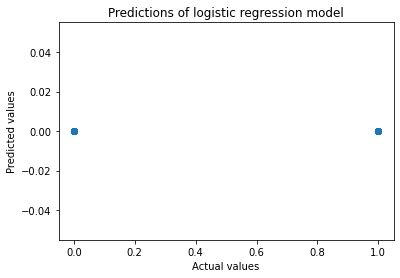

In [9]:
# Make predictions on the test set using the logistic regression model
y_pred = clf.predict(X_test)

# Create a scatter plot to visualize the predictions
plt.scatter(y_test, y_pred)
plt.xlabel('Actual values')
plt.ylabel('Predicted values')
plt.title('Predictions of logistic regression model')
plt.show()

In [41]:
# Select rows where officialPosition is in the list of offensive line positions
df_ol = df[df['officialPosition'].isin(['G', 'T', 'C'])]

# Select rows where officialPosition is in the list of defender positions
df_def = df[df['officialPosition'].isin(['OLB', 'CB', 'SS', 'FS', 'DE', 'NT', 'MLB', 'DT', 'ILB'])]

In [42]:
# Import necessary libraries Offensive side
import tensorflow as tf

# Extract the features and label from the dataframe
features = df_def[['height_inches', 'weight', 'down', 'yardsToGo', 'defendersInBox', 'pff_hit', 'pff_hurry', 'pff_sack']].values
label = df_def['pff_beatTheLine'].values

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, label, test_size=0.2, random_state=42)

# Build the model
def_model = tf.keras.Sequential()
def_model.add(tf.keras.layers.Dense(units=16, activation='relu', input_shape=(8,)))
def_model.add(tf.keras.layers.Dense(units=8, activation='relu'))
def_model.add(tf.keras.layers.Dense(units=4, activation='relu'))
def_model.add(tf.keras.layers.Dense(units=1, activation='sigmoid'))

# Compile the model
def_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
def_model.fit(X_train, y_train, epochs=10, batch_size=32)

# Evaluate the model on the test data
loss, accuracy = def_model.evaluate(X_test, y_test)
print("Test loss:", loss)
print("Test accuracy:", accuracy)

Epoch 1/10
2350/2350 [==============================] - 2s 675us/step - loss: 0.1329 - accuracy: 0.9603
Epoch 2/10
2350/2350 [==============================] - 2s 671us/step - loss: 0.0054 - accuracy: 0.9996
Epoch 3/10
2350/2350 [==============================] - 2s 670us/step - loss: 3.4558e-04 - accuracy: 1.0000
Epoch 4/10
2350/2350 [==============================] - 2s 666us/step - loss: 6.7686e-05 - accuracy: 1.0000
Epoch 5/10
2350/2350 [==============================] - 2s 669us/step - loss: 1.5992e-05 - accuracy: 1.0000
Epoch 6/10
2350/2350 [==============================] - 2s 685us/step - loss: 3.9811e-06 - accuracy: 1.0000
Epoch 7/10
2350/2350 [==============================] - 2s 673us/step - loss: 1.0528e-06 - accuracy: 1.0000
Epoch 8/10
2350/2350 [==============================] - 2s 668us/step - loss: 2.8388e-07 - accuracy: 1.0000
Epoch 9/10
2350/2350 [==============================] - 2s 670us/step - loss: 7.8545e-08 - accuracy: 1.0000
Epoch 10/10
588/588 [===============

In [43]:
# Import necessary libraries Offensive side
import tensorflow as tf

# Extract the features and label from the dataframe
features = df_ol[['height_inches', 'weight', 'down', 'yardsToGo', 'defendersInBox', 'pff_hitAllowed', 'pff_hurryAllowed', 'pff_sackAllowed']].values
label = df_ol['pff_beatenByDefender'].values

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, label, test_size=0.2, random_state=42)

# Build the model
of_model = tf.keras.Sequential()
of_model.add(tf.keras.layers.Dense(units=16, activation='relu', input_shape=(8,)))
of_model.add(tf.keras.layers.Dense(units=8, activation='relu'))
of_model.add(tf.keras.layers.Dense(units=4, activation='relu'))
of_model.add(tf.keras.layers.Dense(units=1, activation='sigmoid'))

# Compile the model
of_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
of_model.fit(X_train, y_train, epochs=10, batch_size=32)

# Evaluate the model on the test data
loss, accuracy = of_model.evaluate(X_test, y_test)
print("Test loss:", loss)
print("Test accuracy:", accuracy)

Epoch 1/10
1073/1073 [==============================] - 1s 671us/step - loss: 1.3575 - accuracy: 0.9291
Epoch 2/10
1073/1073 [==============================] - 1s 682us/step - loss: 0.1905 - accuracy: 0.9586
Epoch 3/10
1073/1073 [==============================] - 1s 684us/step - loss: 0.1892 - accuracy: 0.9586
Epoch 4/10
1073/1073 [==============================] - 1s 679us/step - loss: 0.1839 - accuracy: 0.9586
Epoch 5/10
1073/1073 [==============================] - 1s 670us/step - loss: 0.1846 - accuracy: 0.9586
Epoch 6/10
1073/1073 [==============================] - 1s 671us/step - loss: 0.1802 - accuracy: 0.9586
Epoch 7/10
1073/1073 [==============================] - 1s 673us/step - loss: 0.1805 - accuracy: 0.9586
Epoch 8/10
1073/1073 [==============================] - 1s 671us/step - loss: 0.1799 - accuracy: 0.9586
Epoch 9/10
1073/1073 [==============================] - 1s 671us/step - loss: 0.1807 - accuracy: 0.9586
Epoch 10/10
269/269 [==============================] - 0s 558us/

In [44]:
# Make predictions on the testing data
of_predictions = of_model.predict(X_test)
of_predictions

269/269 [==============================] - 0s 496us/step


array([[0.0566643 ],
       [0.06441825],
       [0.07291259],
       ...,
       [0.0593234 ],
       [0.0599206 ],
       [0.07658197]], dtype=float32)

In [45]:
# Make predictions on the testing data
def_predictions = def_model.predict(X_test)
def_predictions

269/269 [==============================] - 0s 502us/step


array([[0.03828557],
       [0.04594086],
       [0.03513706],
       ...,
       [0.0375583 ],
       [0.03516889],
       [0.0386085 ]], dtype=float32)

In [27]:
# Select the features and target for the offensive linemen data
X = df_ol[['defendersInBox', 'pff_hitAllowed', 'pff_hurryAllowed', 'pff_sackAllowed']]
y = df_ol['pff_beatenByDefender']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [28]:
# Define the model
model = keras.Sequential()
model.add(keras.layers.Dense(32, input_dim=4, activation='relu'))
model.add(keras.layers.Dense(16, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid'))

# Compile the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model
model.fit(X_train, y_train, epochs=10, batch_size=32)

Epoch 1/10
1073/1073 [==============================] - 1s 655us/step - loss: 0.1893 - accuracy: 0.9476
Epoch 2/10
1073/1073 [==============================] - 1s 668us/step - loss: 0.1722 - accuracy: 0.9586
Epoch 3/10
1073/1073 [==============================] - 1s 659us/step - loss: 0.1713 - accuracy: 0.9586
Epoch 4/10
1073/1073 [==============================] - 1s 657us/step - loss: 0.1706 - accuracy: 0.9586
Epoch 5/10
1073/1073 [==============================] - 1s 652us/step - loss: 0.1706 - accuracy: 0.9586
Epoch 6/10
1073/1073 [==============================] - 1s 649us/step - loss: 0.1706 - accuracy: 0.9586
Epoch 7/10
1073/1073 [==============================] - 1s 740us/step - loss: 0.1701 - accuracy: 0.9586
Epoch 8/10
1073/1073 [==============================] - 1s 656us/step - loss: 0.1700 - accuracy: 0.9586
Epoch 9/10
1073/1073 [==============================] - 1s 652us/step - loss: 0.1699 - accuracy: 0.9586
Epoch 10/10
1073/1073 [==============================] - 1s 656u

In [ ]:
from keras.models import Sequential
from keras.layers import Dense

# Define the model architecture
model = Sequential()
model.add(Dense(10, input_dim=8, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model
model.fit(X_train, y_train, epochs=10, batch_size=32)

In [11]:
from sklearn.neighbors import KNeighborsClassifier

df = trainingData

X = df[['height_inches', 'weight', 'down', 'yardsToGo', 'defendersInBox', 'pff_hitAllowed', 'pff_hurryAllowed', 'pff_sackAllowed']]
y = df['pff_beatenByDefender']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# Create the KNN classifier
offensive_knn = KNeighborsClassifier(n_neighbors=5)

# Train the classifier using the training data
offensive_knn.fit(X_train, y_train)

# Use the trained classifier to make predictions on the test data
y_pred = offensive_knn.predict(X_test)

# Calculate the accuracy of the model
accuracy = offensive_knn.score(X_test, y_test)
print('Accuracy:', accuracy)

Accuracy: 0.9872086686115474


In [13]:
df = trainingData

X = df[['height_inches', 'weight', 'down', 'yardsToGo', 'defendersInBox']]
y = df['pff_hit', 'pff_hurry', 'pff_sack']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# Create the KNN classifier
defensive_knn = KNeighborsClassifier(n_neighbors=5)

# Train the classifier using the training data
defensive_knn.fit(X_train, y_train)

# Use the trained classifier to make predictions on the test data
y_pred = defensive_knn.predict(X_test)

# Calculate the accuracy of the model
accuracy = defensive_knn.score(X_test, y_test)
print('Accuracy:', accuracy)

KeyError: ('pff_hit', 'pff_hurry', 'pff_sack')

In [345]:
y_pred = offensive_knn.predict(X_test)
report = classification_report(y_test, y_pred)
print(report)

              precision    recall  f1-score   support

         0.0       0.99      1.00      0.99     30834
         1.0       0.50      0.01      0.01       359

    accuracy                           0.99     31193
   macro avg       0.74      0.50      0.50     31193
weighted avg       0.98      0.99      0.98     31193



In [346]:
y_pred = defensive_knn.predict(X_test)
report = classification_report(y_test, y_pred)
print(report)

              precision    recall  f1-score   support

         0.0       0.99      1.00      0.99     30834
         1.0       0.00      0.00      0.00       359

    accuracy                           0.99     31193
   macro avg       0.49      0.50      0.50     31193
weighted avg       0.98      0.99      0.98     31193



In [256]:
tackle = trainingData[trainingData["nflId"] == 37082]
tackle

,gameId,playId,nflId,displayName,officialPosition,pff_positionLinedUp,height_inches,weight,team,down,yardsToGo,defendersInBox,pff_hitAllowed,pff_hurryAllowed,pff_sackAllowed,pff_beatenByDefender,pff_hit,pff_hurry,pff_sack,maximum_acceleration,maximum_speed,weight_kg,maximum_acceleration_m_s2,potential_force
0,2021090900,282,37082,Tyron Smith,T,LT,77,320.0,DAL,1,10,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.31,5.42,145.149558,1.618488,234.922818
1701,2021090900,735,37082,Tyron Smith,T,LT,77,320.0,DAL,2,3,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.31,5.42,145.149558,1.618488,234.922818
4708,2021090900,1587,37082,Tyron Smith,T,LT,77,320.0,DAL,3,3,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.31,5.42,145.149558,1.618488,234.922818
5178,2021090900,1776,37082,Tyron Smith,T,LT,77,320.0,DAL,2,3,7.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.31,5.42,145.149558,1.618488,234.922818
5448,2021090900,1918,37082,Tyron Smith,T,LT,77,320.0,DAL,2,6,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.31,5.42,145.149558,1.618488,234.922818
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6368010,2021101710,1379,37082,Tyron Smith,T,LT,77,320.0,DAL,2,10,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.31,5.42,145.149558,1.618488,234.922818
6368298,2021101710,1479,37082,Tyron Smith,T,LT,77,320.0,DAL,2,11,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.31,5.42,145.149558,1.618488,234.922818
6369676,2021101710,2211,37082,Tyron Smith,T,LT,77,320.0,DAL,2,9,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.31,5.42,145.149558,1.618488,234.922818
6374380,2021101710,3935,37082,Tyron Smith,T,LT,77,320.0,DAL,1,10,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.31,5.42,145.149558,1.618488,234.922818


In [257]:
defensiveTackle = trainingData[trainingData["officialPosition"] == 'DT']
defensiveTackle

,gameId,playId,nflId,displayName,officialPosition,pff_positionLinedUp,height_inches,weight,team,down,yardsToGo,defendersInBox,pff_hitAllowed,pff_hurryAllowed,pff_sackAllowed,pff_beatenByDefender,pff_hit,pff_hurry,pff_sack,maximum_acceleration,maximum_speed,weight_kg,maximum_acceleration_m_s2,potential_force
2535,2021090900,947,53504,Osa Odighizuwa,DT,RE,74,280.0,DAL,3,5,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.89,6.97,127.005864,1.490472,189.298684
2584,2021090900,1078,42560,Rakeem Nunez-Roches,DT,NLT,74,307.0,TB,2,8,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.23,6.77,139.252858,1.594104,221.983537
4816,2021091207,218,47802,Jeffery Simmons,DT,DLT,76,300.0,TEN,1,18,7.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.74,8.02,136.077711,1.749552,238.075031
4869,2021091207,218,53073,Teair Tart,DT,NRT,75,290.0,TEN,1,18,7.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.19,7.29,131.541787,1.581912,208.087532
5096,2021091207,386,47802,Jeffery Simmons,DT,RE,76,300.0,TEN,2,24,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.74,8.02,136.077711,1.749552,238.075031
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6587256,2021103107,488,44877,Larry Ogunjobi,DT,RE,75,305.0,CIN,1,10,7.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,5.60,8.10,138.345673,1.706880,236.139462
6588509,2021103107,1311,46138,B.J. Hill,DT,DLT,75,311.0,CIN,1,10,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.55,8.05,141.067227,1.691640,238.634964
6588732,2021103107,1531,43301,Sheldon Rankins,DT,DLT,74,305.0,NYJ,2,10,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.09,7.36,138.345673,1.551432,214.633904
6589029,2021103107,1601,46249,Folorunso Fatukasi,DT,NT,76,318.0,NYJ,2,2,9.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,5.05,7.17,144.242374,1.539240,222.023631


In [258]:
listofDT = defensiveTackle["nflId"].tolist()
listofDT

[53504,
 42560,
 47802,
 53073,
 47802,
 47802,
 47802,
 53073,
 52522,
 52522,
 53621,
 53621,
 52522,
 42560,
 53504,
 53504,
 46153,
 47811,
 38542,
 38542,
 46153,
 43441,
 53502,
 46082,
 42480,
 46082,
 43405,
 43441,
 43378,
 44829,
 44829,
 42480,
 42480,
 52830,
 42480,
 46082,
 43378,
 43378,
 43378,
 43378,
 46082,
 53618,
 43441,
 46232,
 38542,
 43405,
 53502,
 52792,
 43338,
 43405,
 46144,
 43338,
 52640,
 37104,
 52792,
 43338,
 43319,
 38667,
 47792,
 43326,
 44847,
 44847,
 44847,
 38667,
 37104,
 46144,
 38667,
 43319,
 43319,
 43326,
 43638,
 38667,
 47792,
 37104,
 47796,
 46307,
 43319,
 46165,
 46307,
 37104,
 46249,
 41341,
 53467,
 53467,
 53467,
 47796,
 43301,
 46307,
 52592,
 41341,
 46307,
 41341,
 42553,
 43301,
 48599,
 52592,
 52665,
 52665,
 48544,
 44877,
 52665,
 44877,
 42349,
 44877,
 44877,
 42349,
 42349,
 42349,
 39959,
 44877,
 44877,
 44867,
 46138,
 44877,
 42349,
 44877,
 39959,
 42826,
 45011,
 38619,
 41239,
 41239,
 41239,
 41239,
 48123,


In [286]:
randorando = random.choice(listofDT)

dfDT = defensiveTackle[defensiveTackle["nflId"] == randorando]
dfDT

,gameId,playId,nflId,displayName,officialPosition,pff_positionLinedUp,height_inches,weight,team,down,yardsToGo,defendersInBox,pff_hitAllowed,pff_hurryAllowed,pff_sackAllowed,pff_beatenByDefender,pff_hit,pff_hurry,pff_sack,maximum_acceleration,maximum_speed,weight_kg,maximum_acceleration_m_s2,potential_force
126686,2021091900,1198,53587,Daviyon Nixon,DT,DRT,75,305.0,CAR,2,19,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.4,8.48,138.345673,1.64592,227.70591
133427,2021091900,3148,53587,Daviyon Nixon,DT,DLT,75,305.0,CAR,1,10,7.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.4,8.48,138.345673,1.64592,227.70591
378475,2021100303,2637,53587,Daviyon Nixon,DT,DRT,75,305.0,CAR,1,6,7.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.4,8.48,138.345673,1.64592,227.70591
472317,2021101001,3707,53587,Daviyon Nixon,DT,DRT,75,305.0,CAR,2,4,6.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,5.4,8.48,138.345673,1.64592,227.70591
583540,2021101702,606,53587,Daviyon Nixon,DT,DRT,75,305.0,CAR,2,7,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.4,8.48,138.345673,1.64592,227.70591
584990,2021101702,1224,53587,Daviyon Nixon,DT,DRT,75,305.0,CAR,2,6,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.4,8.48,138.345673,1.64592,227.70591
876218,2021091202,1752,53587,Daviyon Nixon,DT,DLT,75,305.0,CAR,1,10,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.4,8.48,138.345673,1.64592,227.70591
876361,2021091202,1774,53587,Daviyon Nixon,DT,DLT,75,305.0,CAR,2,10,7.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.4,8.48,138.345673,1.64592,227.70591
880644,2021091202,2949,53587,Daviyon Nixon,DT,LE,75,305.0,CAR,1,10,6.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,5.4,8.48,138.345673,1.64592,227.70591
1042673,2021092300,1511,53587,Daviyon Nixon,DT,DLT,75,305.0,CAR,2,9,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.4,8.48,138.345673,1.64592,227.70591


In [309]:
# Select rows where officialPosition is in the list of offensive line positions
df_ol = testData[testData['officialPosition'].isin(['G', 'T', 'C'])]

# Select rows where officialPosition is in the list of defender positions
df_def = testData[testData['officialPosition'].isin(['OLB', 'CB', 'SS', 'FS', 'DE', 'NT', 'MLB', 'DT', 'ILB'])]

In [401]:
# Step 2: Preprocess the data
# Select the features for each dataframe
ol_features = df_ol[['height_inches', 'weight', 'down', 'yardsToGo', 'defendersInBox', 'pff_hitAllowed', 'pff_hurryAllowed', 'pff_sackAllowed']]
def_features = df_def[['height_inches', 'weight', 'down', 'yardsToGo', 'defendersInBox', 'pff_hit', 'pff_hurry', 'pff_sack']]

# Standardize the features
ol_features = StandardScaler().fit_transform(ol_features)
def_features = StandardScaler().fit_transform(def_features)

# Split the data into training and testing sets
ol_X_train, ol_X_test, ol_y_train, ol_y_test = train_test_split(ol_features, df_ol['pff_beatenByDefender'], test_size=0.2, random_state=42)
def_X_train, def_X_test, def_y_train, def_y_test = train_test_split(def_features, df_def[['pff_hit', 'pff_hurry', 'pff_sack']], test_size=0.2, random_state=42)

# Step 3: Train the KNN models
offensive_knn = KNeighborsClassifier(n_neighbors=5)
defensive_knn = KNeighborsClassifier(n_neighbors=5)

offensive_knn.fit(ol_X_train, ol_y_train)
defensive_knn.fit(def_X_train, def_y_train)

# Step 4: Create the interactive interface
# Create a dropdown menu for player A
# Create a dropdown menu for player A
player_a_dropdown = widgets.Dropdown(
    options=df_ol['nflId'].values,  # modify the options list to include only the nflId values
    value=df_ol['nflId'].values[0],  # use the nflId values as the value of the widget
    description='Player A:',
    disabled=False,
)

# Create a dropdown menu for player B
player_b_dropdown = widgets.Dropdown(
    options=df_def['nflId'].values,  # modify the options list to include only the nflId values
    value=df_def['nflId'].values[0],  # use the nflId values as the value of the widget
    description='Player B:',
    disabled=False,
)

# Define the function for predicting the outcome
def predict_outcome(player_a, player_b):
    # Select the player rows from the dataframes based on the nflId values
    player_a_row = df_ol[df_ol['nflId'] == player_a]
    player_b_row = df_def[df_def['nflId'] == player_b]
    
    # Extract the features for each player
    player_a_features = player_a_row[['height_inches', 'weight', 'down', 'yardsToGo', 'defendersInBox', 'pff_hitAllowed', 'pff_hurryAllowed', 'pff_sackAllowed']].values
    player_b_features = player_b_row[['height_inches', 'weight', 'down', 'yardsToGo', 'defendersInBox', 'pff_hit', 'pff_hurry', 'pff_sack']].values
    
    # Make the prediction using the KNN model
    player_a_prediction = offensive_knn.predict(player_a_features)[0]
    player_b_prediction = defensive_knn.predict(player_b_features)[0]

    # Make the prediction using the KNN model
    player_a_proba = offensive_knn.predict_proba(player_a_features)[0][player_a_prediction]
    player_b_proba = defensive_knn.predict_proba(player_b_features)[0][player_b_prediction]
    
    # Return the prediction for each player
    return player_a_prediction, player_b_prediction, player_a_proba, player_b_proba

# Create the interactive interface
interactive_interface = interactive(predict_outcome, player_a=player_a_dropdown, player_b=player_b_dropdown)

# Display the interactive interface
interactive_interface

interactive(children=(Dropdown(description='Player A:', options=(37082, 43447, 52554, 46075, 44943, 42477, 449…

In [353]:
import ipywidgets as widgets

# Create a dropdown menu for team A
team_a_dropdown = widgets.Dropdown(
    options=df_ol['team'].unique(),
    value=df_ol['team'].unique()[0],  # Set the value to the first item in the list
    description='Team A:',
    disabled=False,
)

# Create a dropdown menu for team B
team_b_dropdown = widgets.Dropdown(
    options=df_def['team'].unique(),
    value=df_def['team'].unique()[0],  # Set the value to the first item in the list
    description='Team B:',
    disabled=False,
)

# Create a dropdown menu for player A
player_a_dropdown = widgets.Dropdown(
    options=df_ol['displayName'].unique(),
    value=df_ol['displayName'].unique()[0],  # Set the value to the first item in the list
    description='Player A:',
    disabled=False,
)

# Create a dropdown menu for player B
player_b_dropdown = widgets.Dropdown(
    options=df_def['displayName'].unique(),
    value=df_def['displayName'].unique()[0],  # Set the value to the first item in the list
    description='Player B:',
    disabled=False,
)

In [375]:
def predict_outcome(player_a,player_b):
    # Get the selected player's name
    player_a_name = player_a_dropdown.value
    player_b_name = player_b_dropdown.value
    
    # Select the player rows from the dataframes based on the displayName values
    player_a_row = df_ol.loc[df_ol['displayName'] == player_a_name]
    player_b_row = df_def.loc[df_def['displayName'] == player_b_name]
    
    # Extract the features for each player
    player_a_features = player_a_row[['height_inches', 'weight', 'down', 'yardsToGo', 'defendersInBox', 'pff_hitAllowed', 'pff_hurryAllowed', 'pff_sackAllowed']]
    player_b_features = player_b_row[['height_inches', 'weight', 'down', 'yardsToGo', 'defendersInBox', 'pff_hit', 'pff_hurry', 'pff_sack']]
    
    # Make the prediction using the KNN model
    player_a_prediction = offensive_knn.predict(player_a_features)[0]
    player_b_prediction = defensive_knn.predict(player_b_features)[0]

    # Print the predictions
    print(f"Prediction for Player A: {player_a_prediction}")
    print(f"Prediction for Player B: {player_b_prediction}")
    
    # Return the prediction for each player
    return player_a_prediction, player_b_prediction

# Create the interactive interface
interactive_interface = interactive(predict_outcome, player_a=player_a_dropdown, player_b=player_b_dropdown)

# Display the interactive interface
interactive_interface

interactive(children=(Dropdown(description='Player A:', options=('Tyron Smith', 'Brandon Shell', 'Tyler Biadas…

In [366]:


def predict_outcome(player_a,player_b):
    # Get the selected player's name
    player_a_name = player_a_dropdown.value
    player_b_name = player_b_dropdown.value
    
    # Select the player rows from the dataframes based on the displayName values
    player_a_row = df_ol.loc[df_ol['displayName'] == player_a_name]
    player_b_row = df_def.loc[df_def['displayName'] == player_b_name]
    
    # Extract the features for each player
    player_a_features = player_a_row[['height_inches', 'weight', 'down', 'yardsToGo', 'defendersInBox', 'pff_hitAllowed', 'pff_hurryAllowed', 'pff_sackAllowed']]
    player_b_features = player_b_row[['height_inches', 'weight', 'down', 'yardsToGo', 'defendersInBox', 'pff_hit', 'pff_hurry', 'pff_sack']]
    
    # Make the prediction using the KNN model
    player_a_prediction = offensive_knn.predict(player_a_features)[0]
    player_b_prediction = defensive_knn.predict(player_b_features)[0]

    # Print the predictions
    print(f"Prediction for Player A: {player_a_prediction}")
    print(f"Prediction for Player B: {player_b_prediction}")
    
    # Return the prediction for each player
    return player_a_prediction, player_b_prediction

# Create the output widget
output_widget = widgets.Output()

# Create the interactive interface
interactive_interface = interactive(predict_outcome, player_a=player_a_dropdown, player_b=player_b_dropdown)

interactive_interface.observe(lambda change: output_widget.clear_output(), names='value')
interactive_interface.observe(lambda change: output_widget.append_stdout(predict_outcome(**change.new)), names='value')

# Display the interactive interface and the output widget
display(interactive_interface, output_widget)

interactive(children=(Dropdown(description='Player A:', index=2, options=('Tyron Smith', 'Brandon Shell', 'Tyl…

Output()